[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kjmobile/lb/blob/main/5_1_Logistic_Regression_Q2.ipynb)


# Understanding Logistic Regression

## Goal: Predict Flight Cancellations

In this notebook, we use logistic regression to predict whether a flight will be cancelled.

## 1. Load and Explore Data

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
url = "https://raw.githubusercontent.com/kjmobile/data/main/ml/flights_50k.csv"
df = pd.read_csv(url)

print(f"Data shape: {df.shape}")
print(f"\nCancellation rate:")
print(df['CANCELLED'].value_counts(normalize=True))

Data shape: (50000, 31)

Cancellation rate:
CANCELLED
0    0.98456
1    0.01544
Name: proportion, dtype: float64


## 2. Prepare Data

Select simple features for logistic regression.

**Important Notes:**
- We exclude `DEPARTURE_DELAY` because:
  - Cancelled flights never departed, so this value is missing for all cancelled cases
  - At prediction time (before departure), this future information is not available (**data leakage**)
- This is an **imbalanced dataset** (~1.5% cancellations)

In [18]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [19]:
df.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,10,29,4,EV,2851,N667GB,12951,11298,1040,...,1205.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,8,17,1,UA,1949,N36280,SEA,ORD,42,...,732.0,52.0,0,0,NaN,0.0,0.0,5.0,47.0,0.0


In [20]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [22]:
# Select relevant columns (excluding DEPARTURE_DELAY to avoid data leakage)
columns_to_use = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'DISTANCE', 
                  'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'CANCELLED']


df_clean = df[columns_to_use].copy()

# Remove missing values
df_clean = df_clean.dropna()

# Encode AIRLINE as numeric
df_clean['AIRLINE_CODE'] = pd.Categorical(df_clean['AIRLINE']).codes
df_clean['ORIGIN_CODE'] = pd.Categorical(df_clean['ORIGIN_AIRPORT']).codes
df_clean['DEST_CODE'] = pd.Categorical(df_clean['DESTINATION_AIRPORT']).codes
df_clean['DEPARTURE_HOUR'] = df_clean['SCHEDULED_DEPARTURE'] // 100

print(f"Clean data shape: {df_clean.shape}")
print(f"Cancellations: {df_clean['CANCELLED'].sum()} ({df_clean['CANCELLED'].mean():.2%})")
df_clean.head()

Clean data shape: (50000, 14)
Cancellations: 772 (1.54%)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,DISTANCE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,CANCELLED,SCHEDULED_TIME,AIRLINE_CODE,ORIGIN_CODE,DEST_CODE,DEPARTURE_HOUR
0,10,29,4,EV,351,12951,11298,1040,0,93.0,4,124,60,10
1,8,17,1,UA,1721,SEA,ORD,42,0,238.0,10,502,454,0
2,11,12,4,OO,599,SLC,SFO,835,0,131.0,9,511,504,8
3,4,30,4,EV,74,LAN,DTW,1340,0,48.0,4,399,323,13
4,9,10,4,B6,2446,JFK,SAN,1659,0,367.0,2,393,494,16


## 3. Separate Features (X) and Target (y)

In [37]:
X.head()

,MONTH,DAY_OF_WEEK,AIRLINE_CODE,DISTANCE,ORIGIN_CODE,DEST_CODE,DEPARTURE_HOUR
0,10,4,4,351,124,60,10
1,8,1,10,1721,502,454,0
2,11,4,9,599,511,504,8
3,4,4,4,74,399,323,13
4,9,4,2,2446,393,494,16


In [48]:
# Select features (no DEPARTURE_DELAY - we can't know this before the flight)
features = ['MONTH', 'DAY_OF_WEEK', 'AIRLINE_CODE', 'DISTANCE', 'ORIGIN_CODE', 'DEST_CODE', 'DEPARTURE_HOUR']
X = df_clean[features]
y = df_clean['CANCELLED']

print(y)
X.head(2)

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: CANCELLED, Length: 50000, dtype: int64


,MONTH,DAY_OF_WEEK,AIRLINE_CODE,DISTANCE,ORIGIN_CODE,DEST_CODE,DEPARTURE_HOUR
0,10,4,4,351,124,60,10
1,8,1,10,1721,502,454,0


## 4. Split Train/Test Data

In [49]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Training data: (40000, 7)
Test data: (10000, 7)


## 5. Train Logistic Regression Model

Logistic regression is an algorithm for binary classification (0 or 1).

We use `class_weight='balanced'` to handle the imbalanced dataset by giving more weight to the minority class (cancellations).

In [50]:
# Create and train model with balanced class weights
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


## 6. Predict and Evaluate

In [51]:
# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Cancelled', 'Cancelled']))

Accuracy: 0.5852

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      0.58      0.74      9846
    Cancelled       0.02      0.64      0.05       154

     accuracy                           0.59     10000
    macro avg       0.51      0.61      0.39     10000
 weighted avg       0.98      0.59      0.72     10000



## 7. Visualize Confusion Matrix

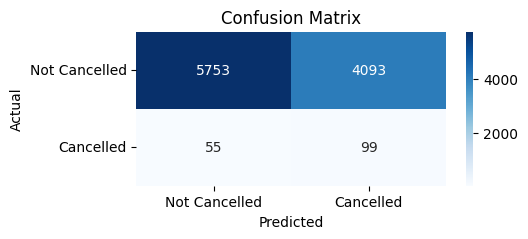

In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Accuracy Calculation:
```
Accuracy = (TP + TN) / Total
         = (99 + 5,753) / 10,000
         = 5,852 / 10,000
         = 0.5852 or 58.52%
```
### Precision (Cancelled) Calculation:
```
Precision = TP / (TP + FP)
          = 99 / (99 + 4,093)
          = 99 / 4,192
          = 0.0236 or 2.36%
```
**Meaning:** Out of 4,192 flights predicted as "Cancelled", only 99 were actually cancelled (98% false alarms!)

### Recall (Cancelled) Calculation:
```
Recall = TP / (TP + FN)
       = 99 / (99 + 55)
       = 99 / 154
       = 0.6429 or 64.29%
```
**Meaning:** Out of 154 actually cancelled flights, the model caught 99 of them (missed 55).


## 8. Check Feature Importance

Examine coefficients to see which features are important for predicting cancellations.

          Feature  Coefficient
6  DEPARTURE_HOUR     0.020057
5       DEST_CODE     0.001058
4     ORIGIN_CODE     0.000375
3        DISTANCE    -0.000457
2    AIRLINE_CODE    -0.007187
1     DAY_OF_WEEK    -0.097205
0           MONTH    -0.109564


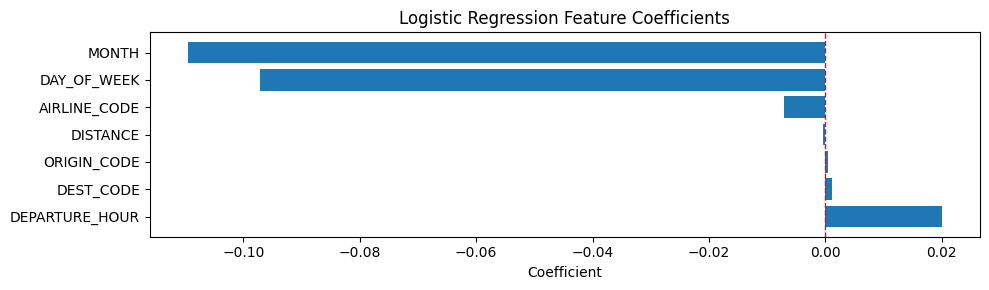

In [53]:
# Feature coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

print(coefficients)

# Visualize
plt.figure(figsize=(10,3))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Logistic Regression Feature Coefficients')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

## 9. Probability Predictions

Logistic regression can predict probabilities, not just 0 or 1.

In [54]:
# Predict probabilities (first 10 samples)
y_prob = model.predict_proba(X_test)[:10]

prob_df = pd.DataFrame({
    'Prob_Not_Cancelled': y_prob[:, 0],
    'Prob_Cancelled': y_prob[:, 1],
    'Predicted': y_pred[:10],
    'Actual': y_test.values[:10]
})

prob_df

,Prob_Not_Cancelled,Prob_Cancelled,Predicted,Actual
0,0.620760,0.379240,0,0
1,0.516090,0.483910,0,0
2,0.576555,0.423445,0,0
3,0.330328,0.669672,1,0
4,0.502023,0.497977,0,0
5,0.275635,0.724365,1,1
6,0.512843,0.487157,0,0
7,0.556924,0.443076,0,0
8,0.447598,0.552402,1,0
9,0.630279,0.369721,0,0


## 10. Predict New Data Example

In [55]:
# New flight data (example)
new_flight = pd.DataFrame({
    'MONTH': [12],  # December
    'DAY_OF_WEEK': [1],  # Monday
    'AIRLINE_CODE': [5],
    'DISTANCE': [2500],  # Long distance flight
    'ORIGIN_CODE': [10],  # Example origin airport code
    'DEST_CODE': [25],  # Example destination airport code
    'DEPARTURE_HOUR': [14]  # 2 PM
})

# Predict
prediction = model.predict(new_flight)[0]
probability = model.predict_proba(new_flight)[0]

print(f"Prediction: {'Cancelled' if prediction == 1 else 'Not Cancelled'}")
print(f"Probability of cancellation: {probability[1]:.2%}")
print(f"Probability of not cancelling: {probability[0]:.2%}")

Prediction: Not Cancelled
Probability of cancellation: 15.63%
Probability of not cancelling: 84.37%


In [59]:
# To see the 'relative probablities of first 10 testset'
y_prob = model.predict_proba(X_test)[:, 1]
y_prob[:10]

array([0.37923957, 0.48391045, 0.42344478, 0.66967163, 0.49797686,
       0.72436467, 0.48715738, 0.443076  , 0.55240229, 0.36972056])

## Note on Probability Calibration

Notice that the model predicts a 15.63% cancellation probability for this flight, which is about 10 times higher than the actual cancellation rate (1.544%) in the dataset. 

**Why does this happen?**
The `class_weight='balanced'` parameter inflates the predicted probabilities to prioritize catching actual cancellations (high recall). This is a known tradeoff:
-  **Pros:** Better at identifying actual cancellations (64% recall)
-  **Cons:** Probability values are not well-calibrated to real-world frequencies

**What does this mean?**
- The **binary predictions** (Cancelled/Not Cancelled) are still useful
- The **relative ordering** of probabilities is meaningful (20% > 15% > 5%)
- The **absolute probability values** should not be interpreted literally

**For better probability estimates in production:**
This issue stems from the imbalanced dataset and class weighting. We may consider in the future meetings: 1) Using probability calibration techniques like `CalibratedClassifierCV` 2) Trying different models that may handle imbalanced data better 3) Collecting more features to improve predictions 4) Adjusting decision thresholds based on business needs rather than raw probabilities.